In [6]:
import json
import numpy as np
import pandas as pd
import torch

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from torch.utils.data import Dataset


In [7]:
file_path = "/content/Sarcasm_Headlines_Dataset.json"
data = []
with open(file_path, "r") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)[["headline", "is_sarcastic"]]
df = df.dropna().drop_duplicates()

print(df.head())
print(df["is_sarcastic"].value_counts())


                                            headline  is_sarcastic
0  former versace store clerk sues over secret 'b...             0
1  the 'roseanne' revival catches up to our thorn...             0
2  mom starting to fear son's web series closest ...             1
3  boehner just wants wife to listen, not come up...             1
4  j.k. rowling wishes snape happy birthday in th...             0
is_sarcastic
0    14951
1    11651
Name: count, dtype: int64


In [8]:
train_temp, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["is_sarcastic"]
)

train_df, dev_df = train_test_split(
    train_temp,
    test_size=0.1,
    random_state=42,
    stratify=train_temp["is_sarcastic"]
)

print("Train size:", len(train_df))
print("Dev size:  ", len(dev_df))
print("Test size: ", len(test_df))


Train size: 19152
Dev size:   2129
Test size:  5321


In [9]:
from torch.utils.data import Dataset

MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def encode_texts(text_list):
    return tokenizer(
        text_list,
        truncation=True,
        padding="max_length",
        max_length=128
    )

class SarcasmDataset(Dataset):
    def __init__(self, texts, labels):
        encodings = encode_texts(texts)
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SarcasmDataset(
    texts=train_df["headline"].tolist(),
    labels=train_df["is_sarcastic"].tolist()
)

dev_dataset = SarcasmDataset(
    texts=dev_df["headline"].tolist(),
    labels=dev_df["is_sarcastic"].tolist()
)

test_dataset = SarcasmDataset(
    texts=test_df["headline"].tolist(),
    labels=test_df["is_sarcastic"].tolist()
)


In [10]:
def model_init():
    return BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    num_train_epochs=5,
    per_device_train_batch_size=8,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    report_to="none"
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.4 MB/s eta 0:00:00


In [14]:
def hp_space_optuna(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1)
    }

best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=hp_space_optuna,
    n_trials=4,
    backend="optuna",
)

print("Best run found:")
print(best_run)


[I 2025-03-17 00:48:23,294] A new study created in memory with name: no-name-a6629e3a-dae7-4d8e-960b-69bd0e0697d0
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.226500,0.202021,0.915923,0.879919,0.935622,0.906916
2,0.150500,0.290375,0.924378,0.892167,0.940987,0.915927
3,0.088600,0.359110,0.928605,0.922078,0.914163,0.918103
4,0.041900,0.390351,0.930484,0.933628,0.905579,0.919390


[I 2025-03-17 01:17:07,040] Trial 0 finished with value: 3.6890814911482277 and parameters: {'learning_rate': 1.3956352769924729e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.0018880921287692367}. Best is trial 0 with value: 3.6890814911482277.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.221600,0.200404,0.923438,0.887992,0.944206,0.915237
2,0.132000,0.275588,0.927666,0.904366,0.933476,0.918691
3,0.069100,0.328431,0.930014,0.929748,0.908798,0.919154


[I 2025-03-17 01:38:35,900] Trial 1 finished with value: 3.6877134585590667 and parameters: {'learning_rate': 1.6257247404003016e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.07729061260115583}. Best is trial 0 with value: 3.6890814911482277.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.269800,0.219409,0.922969,0.886318,0.945279,0.914849
2,0.188100,0.307070,0.928605,0.922078,0.914163,0.918103
3,0.056900,0.364585,0.937529,0.938529,0.917382,0.927835
4,0.000500,0.417078,0.937060,0.939427,0.915236,0.927174


[I 2025-03-17 02:10:56,870] Trial 2 finished with value: 3.718896929739931 and parameters: {'learning_rate': 1.561139748370703e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'weight_decay': 0.023948045178522327}. Best is trial 2 with value: 3.718896929739931.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.244500,0.203476,0.912635,0.886128,0.918455,0.902002
2,0.148600,0.257193,0.922499,0.907545,0.916309,0.911906
3,0.104500,0.300532,0.925317,0.927072,0.900215,0.913446


[I 2025-03-17 02:32:50,859] Trial 3 finished with value: 3.6660493013389597 and parameters: {'learning_rate': 1.0225388825219512e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.03562425915870362}. Best is trial 2 with value: 3.718896929739931.


Best run found:
BestRun(run_id='2', objective=3.718896929739931, hyperparameters={'learning_rate': 1.561139748370703e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'weight_decay': 0.023948045178522327}, run_summary=None)


In [15]:
for k, v in best_run.hyperparameters.items():
    setattr(trainer.args, k, v)

trainer2 = Trainer(
    model_init=model_init,
    args=trainer.args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer2.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.269800,0.219409,0.922969,0.886318,0.945279,0.914849
2,0.188100,0.307070,0.928605,0.922078,0.914163,0.918103
3,0.056900,0.364585,0.937529,0.938529,0.917382,0.927835
4,0.000500,0.417078,0.937060,0.939427,0.915236,0.927174


TrainOutput(global_step=9576, training_loss=0.14523580993557583, metrics={'train_runtime': 1962.7922, 'train_samples_per_second': 39.03, 'train_steps_per_second': 4.879, 'total_flos': 5039102932254720.0, 'train_loss': 0.14523580993557583, 'epoch': 4.0})

In [16]:
test_result = trainer2.predict(test_dataset)
preds = np.argmax(test_result.predictions, axis=-1)
labels = test_result.label_ids

acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print("Final Test Evaluation:")
print(f"Accuracy = {acc:.4f}")
print(f"Precision= {precision:.4f}")
print(f"Recall   = {recall:.4f}")
print(f"F1       = {f1:.4f}")


Final Test Evaluation:
Accuracy = 0.9354
Precision= 0.9421
Recall   = 0.9082
F1       = 0.9248


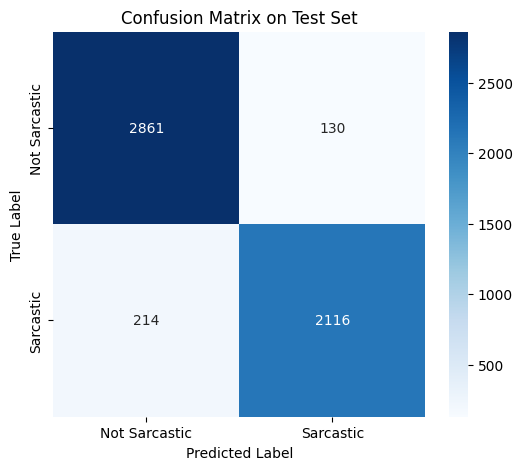

In [17]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Not Sarcastic", "Sarcastic"],
        yticklabels=["Not Sarcastic", "Sarcastic"]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix on Test Set")
    plt.show()

plot_confusion_matrix(labels, preds)


In [18]:
model_save_path = "/content/drive/My Drive/BERT_Sarcasm_Model"
trainer2.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)


('/content/drive/My Drive/BERT_Sarcasm_Model/tokenizer_config.json',
 '/content/drive/My Drive/BERT_Sarcasm_Model/special_tokens_map.json',
 '/content/drive/My Drive/BERT_Sarcasm_Model/vocab.txt',
 '/content/drive/My Drive/BERT_Sarcasm_Model/added_tokens.json')